# Mid-Term Project — Night-Time Image Enhancement

# Goal: 
Given a pair of images of the same scene—one captured at night and the other at day—design and implement your best method to enhance the night-time image so that it matches the day-time appearance as closely as possible.

### Primary evaluation metric:
Mean Squared Error (MSE) between your enhanced image and the day-time image.

### Performance matters: 
Your grade will be impacted by quantitative performance (MSE), alongside method quality and reproducibility.



# MSE
Mean Squared Error (MSE) measures the average squared difference between corresponding pixels of two images. If your enhanced image is compared to a reference day-time image, the formula for MSE is:
<center>

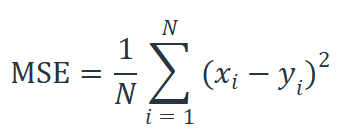

</center>

where:

•   xi = pixel value in the enhanced image

•   yi = pixel value in the day-time image

•   N = total number of pixels (or pixel values)


# Channel-wise MSE
Images typically have 3 color channels: Red (R), Green (G), and Blue (B). Instead of computing one MSE over all channels combined, channel-wise MSE computes MSE separately for each channel:
<center>

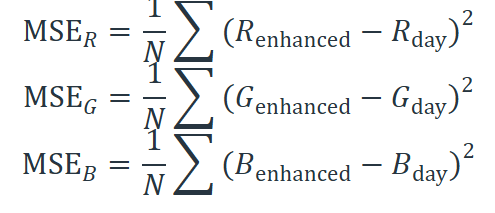
</center>

Then you can average them as the final difference:
<center>

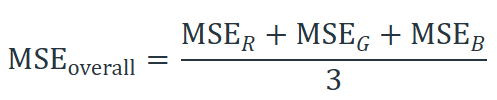
</center>

Please report this number in your report and slides.​

# Important Note on Method Choice
Students are allowed to use any method to achieve the goal—classical, learning-based, or hybrid approaches.
If your chosen method requires training or fine-tuning, you must prepare the training data yourself. The provided image pair is not sufficient for robust training, so you are expected to design or collect additional data (e.g., augmentations, synthetic generation, or external datasets) as needed.

Ensure that your pipeline remains generalizable and does not overfit to the single provided pair.

# Dataset
•  You are provided with one pair of images of the same scene (please check the files in Files/Mid-Term/):

     •  night.png (or .jpg): Night-time capture.

     •  day.png (or .jpg): Day-time capture (the reference/target).

•  Both images may differ in exposure, noise, white balance, and viewpoint (small shifts).

•  Optional: If we release additional hidden pairs, your method will be re-run on those for final grading. Design your pipeline to be robust and not overfit to a single visible pair.

Important constraint (integrity rule): During inference, your pipeline must use only the night-time image. The day-time image can be used for training/supervision, parameter selection, or histogram matching, but it must not be directly copied or blended at test time.

# Academic Integrity & Collaboration
•  You may discuss high-level ideas, but all code must be your own or clearly credited (for any third-party snippets/models).

•  Cite all sources and pretrained models.

•  Clearly mark any borrowed components in the report and code headers.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load images


In [7]:
day = cv2.imread("day.jpg")
night = cv2.imread("night.jpg")

if day is None or night is None:
    raise FileNotFoundError("Where is files?")

# Resize if needed
if day.shape != night.shape:
    night = cv2.resize(night, (day.shape[1], day.shape[0]))


day_rgb = cv2.cvtColor(day, cv2.COLOR_BGR2RGB)
night_rgb = cv2.cvtColor(night, cv2.COLOR_BGR2RGB)

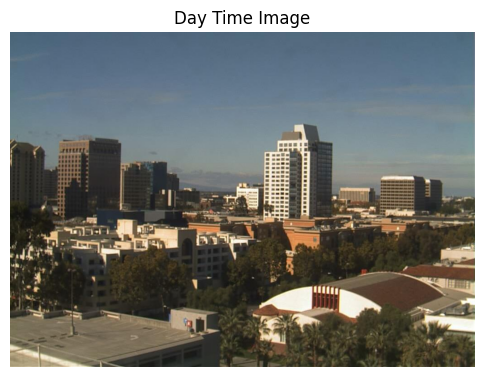

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(day_rgb)
plt.title("Day Time Image")
plt.axis("off")
plt.show()

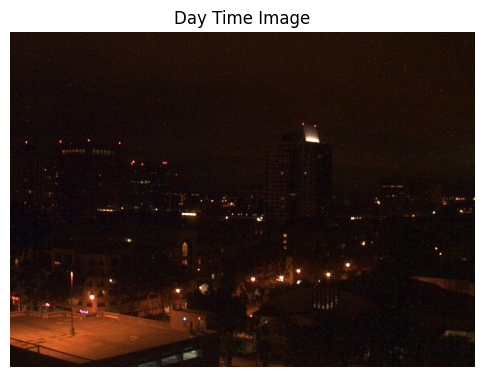

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(night_rgb)
plt.title("Day Time Image")
plt.axis("off")
plt.show()

### Histograms plot


In [10]:
def show_histograms(img1, img2, label2):
    colors = ['r', 'g', 'b']
    channel_names = ['Red', 'Green', 'Blue']
    
    plt.figure(figsize=(12, 8))
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.hist(img1[:,:,i].ravel(), bins=256, alpha=0.5,
                 color=colors[i], label='Day')
        plt.hist(img2[:,:,i].ravel(), bins=256,
                 histtype='step', linewidth=2,
                 color=colors[i], label=label2)
        
        plt.title(f'{channel_names[i]} Channel Histogram')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

### MSE calculations

In [11]:
def compute_channel_mse(img1, img2):
    mse_r = np.mean((img1[:,:,0] - img2[:,:,0]) ** 2)
    mse_g = np.mean((img1[:,:,1] - img2[:,:,1]) ** 2)
    mse_b = np.mean((img1[:,:,2] - img2[:,:,2]) ** 2)
    
    mse_overall = (mse_r + mse_g + mse_b) / 3
    return mse_r, mse_g, mse_b, mse_overall


### Original 

Showing ORIGINAL histograms...


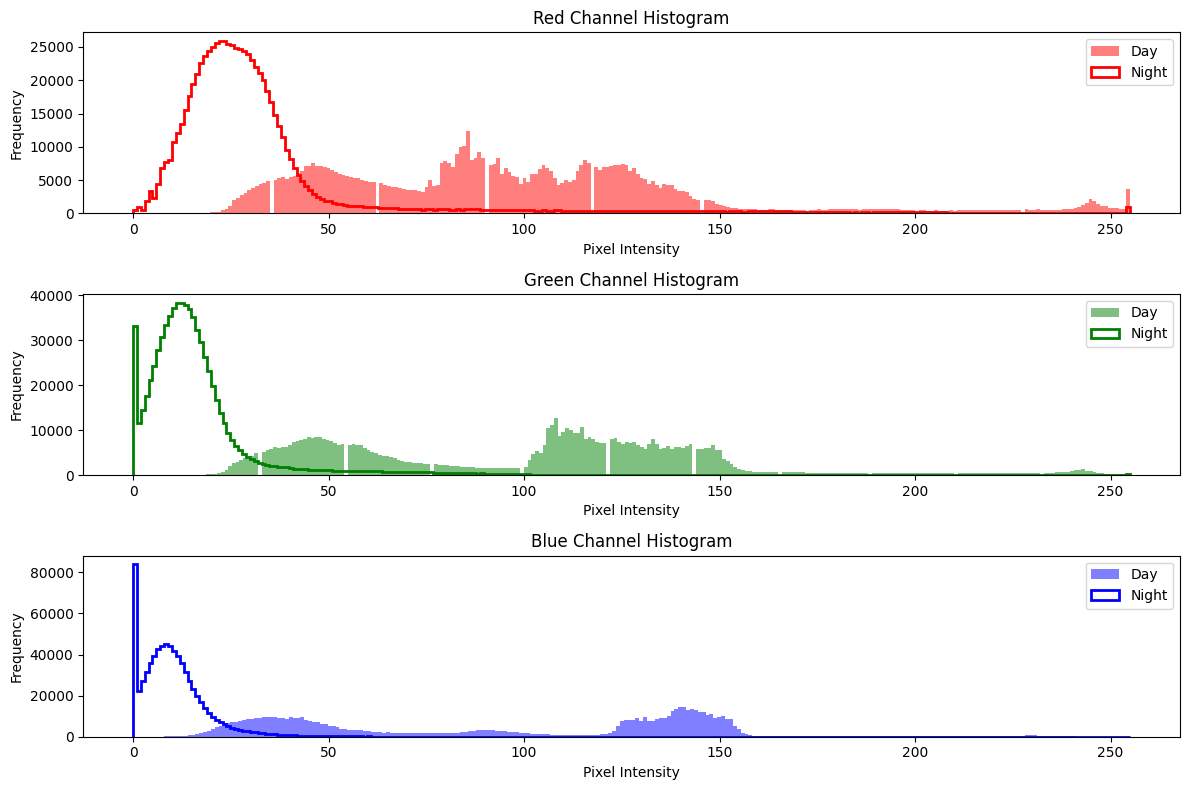


Pixel-wise MSE (BEFORE Matching):
MSE Red:   111.96
MSE Green: 103.62
MSE Blue:  95.26
Overall MSE: 103.61


In [12]:
print("Showing ORIGINAL histograms...")
show_histograms(day_rgb, night_rgb, "Night")

mse_r, mse_g, mse_b, mse_total = compute_channel_mse(night_rgb, day_rgb)

print("\nPixel-wise MSE (BEFORE Matching):")
print(f"MSE Red:   {mse_r:.2f}")
print(f"MSE Green: {mse_g:.2f}")
print(f"MSE Blue:  {mse_b:.2f}")
print(f"Overall MSE: {mse_total:.2f}")

# Histogram mathching per channel

In [13]:
def histogram_match(source, template):
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]

    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [14]:
matched = np.zeros_like(night_rgb)
for i in range(3):
    matched[:,:,i] = histogram_match(night_rgb[:,:,i], day_rgb[:,:,i])

matched = matched.astype(np.uint8)


Showing MATCHED histograms...


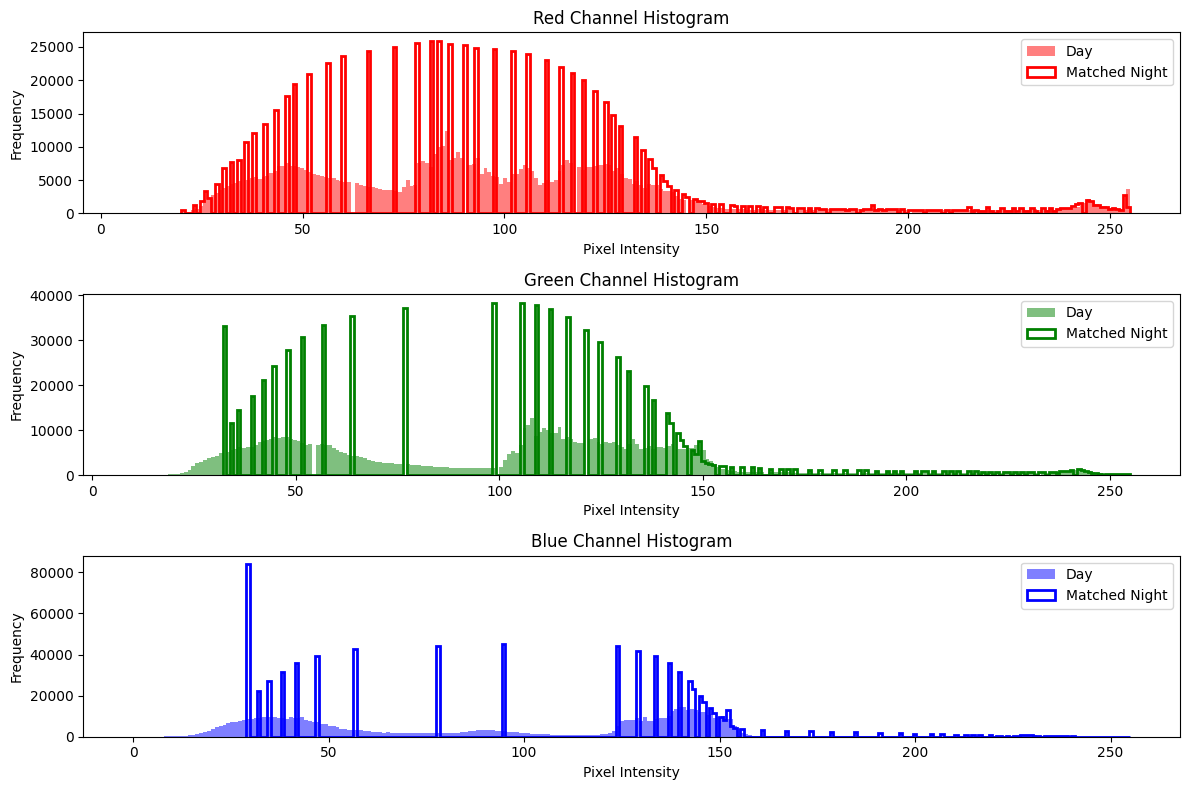


Pixel-wise MSE (AFTER Matching):
MSE Red:   103.44
MSE Green: 100.67
MSE Blue:  98.45
Overall MSE: 100.85


In [15]:
print("\nShowing MATCHED histograms...")
show_histograms(day_rgb, matched, "Matched Night")

mse_r2, mse_g2, mse_b2, mse_total2 = compute_channel_mse(matched, day_rgb)

print("\nPixel-wise MSE (AFTER Matching):")
print(f"MSE Red:   {mse_r2:.2f}")
print(f"MSE Green: {mse_g2:.2f}")
print(f"MSE Blue:  {mse_b2:.2f}")
print(f"Overall MSE: {mse_total2:.2f}")

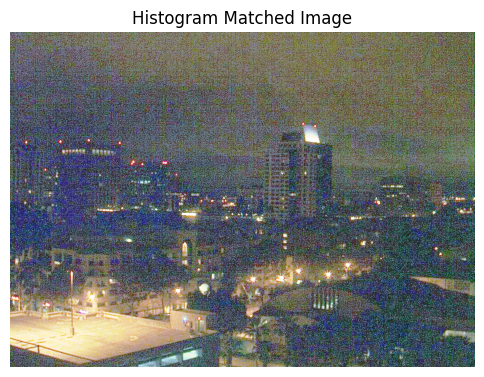

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(matched)
plt.title("Histogram Matched Image")
plt.axis("off")
plt.show()

### Alligment

In [17]:
def align_images(source, target):
    gray1 = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)

    orb = cv2.ORB_create(5000)
    k1, d1 = orb.detectAndCompute(gray1, None)
    k2, d2 = orb.detectAndCompute(gray2, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(d1, d2)
    matches = sorted(matches, key=lambda x: x.distance)

    pts1 = np.float32([k1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([k2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    aligned = cv2.warpPerspective(source, H, (target.shape[1], target.shape[0]))
    return aligned

night_aligned = align_images(night_rgb, day_rgb)

mse_r_a, mse_g_a, mse_b_a, mse_total_a = compute_channel_mse(night_aligned, day_rgb)

print("\nMSE After Alignment Only:")
print(f"MSE Red:   {mse_r_a:.2f}")
print(f"MSE Green: {mse_g_a:.2f}")
print(f"MSE Blue:  {mse_b_a:.2f}")
print(f"Overall MSE: {mse_total_a:.2f}")


MSE After Alignment Only:
MSE Red:   101.37
MSE Green: 101.69
MSE Blue:  99.88
Overall MSE: 100.98


### Denoising

In [18]:
night_denoised = cv2.fastNlMeansDenoisingColored(
    night_rgb, None, 10, 10, 7, 21
)
mse_r_d, mse_g_d, mse_b_d, mse_total_d = compute_channel_mse(night_denoised, day_rgb)

print("\nMSE After Denoising Only:")
print(f"MSE Red:   {mse_r_d:.2f}")
print(f"MSE Green: {mse_g_d:.2f}")
print(f"MSE Blue:  {mse_b_d:.2f}")
print(f"Overall MSE: {mse_total_d:.2f}")


MSE After Denoising Only:
MSE Red:   111.33
MSE Green: 102.74
MSE Blue:  95.70
Overall MSE: 103.26


### Color Transfer

In [19]:
def color_transfer(source, target):
    result = np.zeros_like(source, dtype=np.float32)

    for i in range(3):
        mean_s, std_s = source[:,:,i].mean(), source[:,:,i].std()
        mean_t, std_t = target[:,:,i].mean(), target[:,:,i].std()

        result[:,:,i] = (source[:,:,i] - mean_s) * (std_t / std_s) + mean_t

    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)

night_color_transfer = color_transfer(night_rgb, day_rgb)

mse_r_c, mse_g_c, mse_b_c, mse_total_c = compute_channel_mse(night_color_transfer, day_rgb)

print("\nMSE After Mean-Std Color Transfer:")
print(f"MSE Red:   {mse_r_c:.2f}")
print(f"MSE Green: {mse_g_c:.2f}")
print(f"MSE Blue:  {mse_b_c:.2f}")
print(f"Overall MSE: {mse_total_c:.2f}")


MSE After Mean-Std Color Transfer:
MSE Red:   102.39
MSE Green: 105.82
MSE Blue:  110.64
Overall MSE: 106.28


### All together

In [20]:
denoised = cv2.fastNlMeansDenoisingColored(night_rgb, None, 10, 10, 7, 21)
aligned = align_images(denoised, day_rgb)
transfer = color_transfer(aligned, day_rgb)

matched1 = np.zeros_like(transfer)
for i in range(3):
    matched1[:,:,i] = histogram_match(night_rgb[:,:,i], day_rgb[:,:,i])

matched1 = matched1.astype(np.uint8)





mse_r_all, mse_g_all, mse_b_all, mse_total_all = compute_channel_mse(matched1, day_rgb)

print("\nMSE After Alignment + Denoising + Color Transfer:")
print(f"MSE Red:   {mse_r_all:.2f}")
print(f"MSE Green: {mse_g_all:.2f}")
print(f"MSE Blue:  {mse_b_all:.2f}")
print(f"Overall MSE: {mse_total_all:.2f}")


MSE After Alignment + Denoising + Color Transfer:
MSE Red:   103.44
MSE Green: 100.67
MSE Blue:  98.45
Overall MSE: 100.85


### RETINEX

In [21]:
def single_scale_retinex(img, sigma):
    img = img.astype(np.float32) + 1.0
    blur = cv2.GaussianBlur(img, (0,0), sigma)
    retinex = np.log(img) - np.log(blur)
    return retinex

def multi_scale_retinex(img):
    sigmas = [15, 80, 250]  # standard MSR scales
    result = np.zeros_like(img, dtype=np.float32)
    
    for sigma in sigmas:
        result += single_scale_retinex(img, sigma)
    
    result /= len(sigmas)
    
    # Normalize to 0-255
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
    return result.astype(np.uint8)

night_retinex = multi_scale_retinex(night_denoised)

### Gamma tunning

In [22]:
def apply_gamma(img, gamma):
    img = img.astype(np.float32) / 255.0
    img = np.power(img, gamma)
    img = np.clip(img * 255.0, 0, 255)
    return img.astype(np.uint8)

best_mse = float("inf")
best_gamma = 1.0
best_result = None

for gamma in np.linspace(0.5, 2.5, 21):  # try multiple gammas
    test_img = apply_gamma(night_retinex, gamma)
    _, _, _, mse = compute_channel_mse(test_img, day_rgb)
    
    if mse < best_mse:
        best_mse = mse
        best_gamma = gamma
        best_result = test_img

### RETINEX + GAMMA TUNING (RESULTS)


RETINEX + DENOISE + GAMMA RESULTS
Best Gamma: 0.90
Lowest MSE Achieved: 102.47


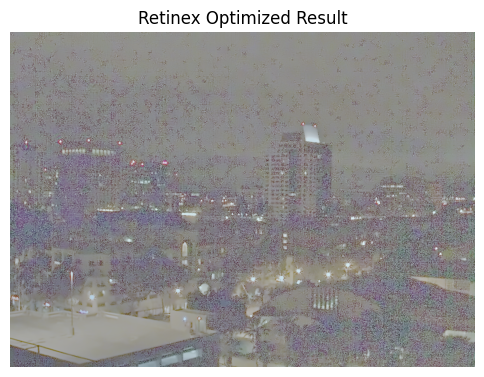

In [23]:
print("\nRETINEX + DENOISE + GAMMA RESULTS")
print(f"Best Gamma: {best_gamma:.2f}")
print(f"Lowest MSE Achieved: {best_mse:.2f}")

plt.figure(figsize=(6,6))
plt.imshow(best_result)
plt.title("Retinex Optimized Result")
plt.axis("off")
plt.show()